# Combining Roads and Bridges Data

In this Jupyter Notebook, roads and bridges data is combined and intersections are made.

In [1]:
import numpy as np
import pandas as pd

The roads and bridges files are loaded in. Note that this Jupyter Notebook needs to be in the same folder as the files

In [2]:
# Import the roads and bridges
roads = pd.read_csv('data/_roads3.csv')
df = pd.read_excel('data/BMMS_overview.xlsx')

Here the main roads are given as input. This is the only thing that the user needs to fill in.

In [3]:
# Give input of main roads here
mainroads = ['N1', 'N2']

The N1 road simulation should start in Dhaka and end in Chittagong. 

The latitude of Chittagong, Bangladesh is 22.341900, and the longitude is 91.815536 [Source](https://www.latlong.net/place/chittagong-bangladesh-14922.html#:~:text=The%20latitude%20of%20Chittagong%2C%20Bangladesh,%C2%B0%2048'%2055.9296''%20E.)

The latitude of Dhaka, Bangladesh is 23.777176, and the longitude is 90.399452 [Source](https://www.latlong.net/place/dhaka-bangladesh-718.html#:~:text=The%20latitude%20of%20Dhaka%2C%20Bangladesh,%C2%B0%2023'%2058.0272''%20E.)

Everything outside these coordinates can be deleted since the road is relatively linear (purple line in the picture).

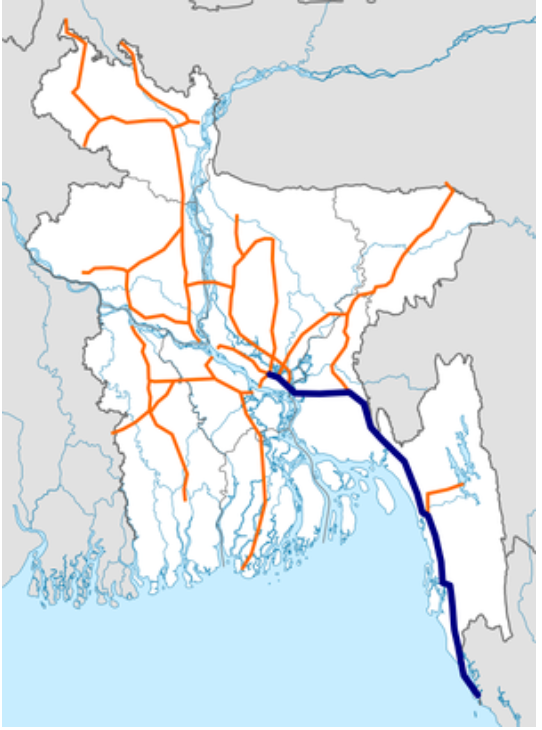

Approach

- Find side roads
- Find the start and end of roads
- Sort roads data by length
- Select roads based on length (>25 km)
- Save start and end of roads in a dataframe

In [4]:
df1= df.copy()
dictmainroads = {}

for road in mainroads:
    df2 = df1.loc[(df1['road'].str.startswith(road, na=False))]
    dictmainroads[road] = df2
    
selectedroads = pd.concat(dictmainroads.values(), ignore_index=True)

# See what are our initial target roads
selectedroads.road.unique()

array(['N1', 'N102', 'N104', 'N105', 'N106', 'N107', 'N108', 'N110', 'N2',
       'N204', 'N205', 'N206', 'N207', 'N208', 'N209'], dtype=object)

In [5]:
# Find end of roads
dictendroads= {}
for road in selectedroads.road.unique():
    sel = roads.loc[(roads['road']== road)]
    select = sel.iloc[-1:]
    dictendroads[road] = select
    
roadends = pd.concat(dictendroads.values(), ignore_index=True)

# Find start of roads
dictstartroads = {}
for road in selectedroads.road.unique():
    sel = roads.loc[(roads['road']== road)]
    select = sel.iloc[:1]
    dictstartroads[road] = select
    
roadstarts = pd.concat(dictstartroads.values(), ignore_index=True)

final_selection = pd.concat((roadends, roadstarts), ignore_index=True)

In [6]:
# Sort entries by road
roadends.sort_values(by='road',inplace=True)

finalselectedroads = roadends.loc[roadends.chainage > 25]

finalselectedroads.road.unique()

array(['N1', 'N102', 'N104', 'N105', 'N106', 'N2', 'N204', 'N207', 'N208'],
      dtype=object)

In [7]:
# Select identified roads
dictfinalselectedroads = {}

for road in finalselectedroads.road.unique():
    selected = final_selection.loc[(final_selection['road']== road)]
    dictfinalselectedroads[road] = selected
    
final_selection = pd.concat(dictfinalselectedroads.values(), ignore_index=True)

In [8]:
# Change name to avoid confusion later
ends=final_selection

The bridges file is also edited. Unnecessary columns are dropped and an extra column is created to combine bridges later.

In [9]:
# Drop unnecessary columns
df1=df.copy()
df1 = df1.drop(['type', 'chainage', 'name', 'structureNr', 'roadName', 'width', 'constructionYear', 'spans', 'zone', 'circle', 'division', 'sub-division', 'EstimatedLoc'], axis=1)
df1.head(5)

,road,km,LRPName,length,condition,lat,lon
0,N1,1.800,LRP001a,11.30,A,23.698739,90.458861
1,N1,4.925,LRP004b,6.60,A,23.694664,90.487775
2,N1,8.976,LRP008b,394.23,A,23.705060,90.523214
3,N1,10.880,LRP010b,6.30,A,23.694391,90.537574
4,N1,10.897,LRP010c,6.30,A,23.694302,90.537707


In [10]:
# Drop duplicates of multiple bridges on the same location later on so remove the LRP extension to enable that.
df2=df1.copy()
df2['LRPnumber'] = df2['LRPName'].str[:6]
df2.head(5)

,road,km,LRPName,length,condition,lat,lon,LRPnumber
0,N1,1.800,LRP001a,11.30,A,23.698739,90.458861,LRP001
1,N1,4.925,LRP004b,6.60,A,23.694664,90.487775,LRP004
2,N1,8.976,LRP008b,394.23,A,23.705060,90.523214,LRP008
3,N1,10.880,LRP010b,6.30,A,23.694391,90.537574,LRP010
4,N1,10.897,LRP010c,6.30,A,23.694302,90.537707,LRP010


The road ends are formatted so they can be put in the bridge dataframe

In [11]:
#format the road ends to the same format as the bridges df
ends['model_type']= "sourcesink"
ends['condition']='K'
ends['length']=1
ends.rename(columns=({"chainage": "km",'lrp':'LRPnumber'}),inplace=True)
ends.drop(['gap', 'type','name'], axis=1,inplace=True)
ends['LRPnumber'] = ends['LRPnumber'].replace(['LRP048'],'LRPE')

Here different roads are combined

- A dataframe for every road is made 
- Duplicate bridges are aggregated into 1 bridge
- The road ends and starts are added to the dataframe
- These are sorted by kilometer (this should not be necessary but it is a assurance that the bridges are in the right order)
- The links are made in a different dataframe
- The length, latitude, and longitude of the links are calculated by taking the average of the two bridges surrounding the link
- The roads and links are combined in one dataframe

In [12]:
# List of all road names needed
relevantroadnames = ends.road.unique()

# Store all roads in dictionary. These will be added together later.
d ={}

#Iterating over all rows
for road in relevantroadnames:
    #Selecting one road in a dataframe
    df3 = df2.loc[df2['road'] == road]
    #Delete duplicates
    aggregation_functions = {'road': 'first', 'km': 'mean', 'length': 'mean', 'condition': 'first', 'lat': 'mean', 'lon': 'mean'}
    df3=df3.groupby(df3['LRPnumber']).aggregate(aggregation_functions).reset_index()
    #Add model type bridge
    df3['model_type']='bridge'
    df3=df3[['road', 'km', 'model_type', 'LRPnumber', 'lat', 'lon', 'length', 'condition']]
    
    #Add first sourcesink
    first = ends.loc[(ends['road']== road) & (ends['km']==0)]
    df3=pd.concat([first,df3])
    #Add second sourcesink
    second = ends.loc[(ends['road']== road) & (ends['km']!=0)]
    df3=pd.concat([df3,second])
    
    #Sort by kilometer
    df3=df3.sort_values(by='km')
    
    #Adding the links between the rows
    dfr1=df3.copy()
    dfr1['model_type']='link'
    #Add right lenght and distance from start
    dfr1['km']=dfr1['km']+(dfr1['length']/1000)
    dfr1['length']=(df3['km'].shift(-1)-dfr1['km'])*1000    #Start of bridge - start of road
    #Add roadname
    dfr1['LRPnumber'] = 'road' + dfr1['LRPnumber'].astype(str)
    #Adding the right latitude and longitude
    dfr1['lat'] = (dfr1['lat']+dfr1['lat'].shift(-1))/2
    dfr1['lon'] = (dfr1['lon']+dfr1['lon'].shift(-1))/2
    
    #Combining the roads and bridges dataframe
    frames = [df3, dfr1]
    dftot = pd.concat(frames)
    dftot = dftot.sort_values(by='km')
    dftot.reset_index(inplace = True)
    #Drop index column
    dftot.drop(columns = ['index'], inplace = True)
    #Drop last row, this is an unnecessary link row
    dftot.drop(dftot.tail(1).index,inplace=True)
    
    d[road]=dftot
    
#Merging the dataframes of the different roads
total = pd.concat(d.values(), ignore_index=True)

C:\Users\Jip\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\Jip\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Some columns are renamed so they fit the Pycharm model

In [13]:
# Rename some columns so they match
total.rename(columns = {'km':'id'}, inplace = True) 
total.rename(columns = {'LRPnumber':'name'}, inplace = True) 

# Reset the id 
total['id'] = total.index

Add the intersections. Note that this analysis assumes that all intersections are at the start or end of a road.

In [14]:
for i in range(len(total)):
    if total.loc[i,'model_type'] == 'sourcesink':
        minimum=1000
        for index, road in total.iterrows():
            if road['road'] != total.loc[i,'road']:
                closeness = abs(road['lat']-total.loc[i,'lat'])+abs(road['lon']-total.loc[i,'lon'])
                if closeness <= minimum:
                    minimum = closeness
                    closest = road['id']
                    
        if minimum <= 0.1:
            if total.loc[i, 'name'] == 'LRPS':
                total.loc[i+1, 'model_type'] = 'intersection'
                total.loc[closest, 'model_type'] = 'intersection'
                total.loc[i+1, 'id'] = total.loc[closest, 'id']
                total.loc[i+1, 'length'] = total.loc[closest, 'length']
                total.loc[i+1, 'lat'] = total.loc[closest, 'lat']
                total.loc[i+1, 'lon'] = total.loc[closest, 'lon']

            if total.loc[i, 'name'] == 'LRPE':
                total.loc[i-1, 'model_type'] = 'intersection'
                total.loc[closest, 'model_type'] = 'intersection'
                total.loc[i-1, 'id'] = total.loc[closest, 'id']
                total.loc[i-1, 'length'] = total.loc[closest, 'length']
                total.loc[i-1, 'lat'] = total.loc[closest, 'lat']
                total.loc[i-1, 'lon'] = total.loc[closest, 'lon']

In [15]:
total.to_csv('Pycharm_roads.csv', index=False)